In [1]:
# Import Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

from sklearn.preprocessing import  MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, cross_validate, learning_curve, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from scipy.stats import uniform, randint
import time
import joblib
import os


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
# Read in pre-processed data from pre-processing step
df = pd.read_csv('../data/pre_processed_churn_df_ready_for_modeling')
df.head()

,Satisfaction Score,Churn Value,Churn Score,CLTV,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Age,Number of Dependents,City,Zip Code,Referred a Friend_Yes,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Offer_Unknown/None,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_DSL,Internet Type_Fiber Optic,Internet Type_None,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Contract_One Year,Contract_Two Year,Paperless Billing_Yes,Payment Method_Credit Card,Payment Method_Mailed Check,Gender_Male,Under 30_Yes,Senior Citizen_Yes,Married_Yes,Dependents_Yes
0,3,1,91,5433,0,1,0.00,8,39.65,39.65,0.00,20,0.00,59.65,78,0,293,90022,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0
1,3,1,69,5302,1,8,48.85,17,80.65,633.30,0.00,0,390.80,1024.10,74,1,293,90063,1,0,0,0,1,0,1,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,1
2,2,1,81,3179,0,18,11.33,52,95.45,1752.55,45.61,0,203.94,1910.88,71,3,293,90065,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,1,1,1,1,0,0,1,0,0,1,0,1,0,1
3,2,1,88,5337,1,25,19.76,12,98.50,2514.50,13.43,0,494.00,2995.07,78,1,25,90303,1,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,1,1,0,1,0,0,1,0,0,0,0,1,1,1
4,2,1,67,2793,1,37,6.33,14,76.50,2868.15,0.00,0,234.21,3102.36,80,1,30,90602,1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Satisfaction Score                 7043 non-null   int64  
 1   Churn Value                        7043 non-null   int64  
 2   Churn Score                        7043 non-null   int64  
 3   CLTV                               7043 non-null   int64  
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Avg Monthly Long Distance Charges  7043 non-null   float64
 7   Avg Monthly GB Download            7043 non-null   int64  
 8   Monthly Charge                     7043 non-null   float64
 9   Total Charges                      7043 non-null   float64
 10  Total Refunds                      7043 non-null   float64
 11  Total Extra Data Charges           7043 non-null   int64

In [4]:
# Split data into Features (also dropping features with churn category & churn reason as this would cause data leakage)
# and target variable 'Churn Value'
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']

In [5]:
#Split data into Train & Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)

In [6]:
# Create scaler: scaler
scaler = MinMaxScaler()

# Create a PCA instance: pca
pca = PCA(n_components=22, random_state=7) # I chose 22 components as this explains 90% of the variance

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to the training data
pipeline.fit(X_train)

# Transform the training and test data
X_train_pipe = pipeline.transform(X_train)
X_test_pipe = pipeline.transform(X_test)

In [7]:
# Undersample from majority as our classes are imbalanced
from imblearn.under_sampling import RandomUnderSampler

# Define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=7)

# Fit and apply the undersampling strategy to the training data
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_pipe, y_train)

## With our data ready, we'll define our modeling, scoring, and cross validation functions to make our work faster and cleaner as we will be testing several models and comparing scoring metrics of each.

## We will then pick two to three models with the best combination of accuracy, recall, precision, and f1, then tune their hyperparameters to create the best possible model.

In [8]:
#Defining the modeling function

def modeling(alg, alg_name, params={}):
    """
    Fits and trains a given model and computes accuracy scores including accuracy,
        precision, recall, f1 score, full classification report, Matthews correlation coefficient,
        & confusion matrix.

    Parameters:
    - alg: the model function we will be testing.
    - alg_name: name of the model we will be testing.
    - params: parameters if any.

    Returns:
    - model.

    Prints:
    - classification report.
    - scoring metrics.
    - confusion matrix.
    
    """
    global y_pred
    model = alg(**params) #Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_pipe)

    #Performance evaluation
    def print_scores(alg, y_test, y_pred):
        print(alg_name)
        acc_score = accuracy_score(y_test, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_test, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_test, y_pred)
        print("recall: ",rec_score)
        f_score = f1_score(y_test, y_pred, average='weighted')
        print("f1_score: ",f_score)

    report = classification_report(y_test, y_pred)
    print(report)
    
    print_scores(alg, y_test, y_pred)

    # Assuming y_test and y_pred are your true labels and predicted labels respectively
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews correlation coefficient:", mcc)

    # Calculate & plot the confusion matrix as a heatmap
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return model

In [9]:
# Define a function to perform cross-validation

def cross_validate_model(model, X, y, cv=10):
    """
    Perform cross-validation on our model

    Parameters:
    - model: the fit model to perform cross validation on.
    - X: features.
    - y: target.

    Returns:
    - cross validation scores.
    """
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # Print cross-validation scores
    print("Cross-validation scores:", cv_scores)
    print("Mean CV accuracy:", cv_scores.mean())
    print("Standard deviation of CV accuracy:", cv_scores.std())

In [10]:
#Define a function to plot the ROC Curve and AUC

def plot_roc_auc(model, y_test, title='Receiver Operating Characteristic (ROC) Curve'):
    """
    Plots the ROC curve and calculates the AUC score.

    Parameters:
    - y_test: array-like, shape (n_samples,)
        True binary labels in range {0, 1} or {-1, 1}.
    - y_proba: array-like, shape (n_samples,)
        Target scores, can either be probability estimates of the positive class,
        confidence values, or binary decisions.
    - title: string, optional (default='Receiver Operating Characteristic (ROC) Curve')
        Title of the plot.

    Returns:
    - auc_score: float
        Computed Area Under the Curve (AUC) score.
    """
    #global y_proba
    y_proba = model.predict_proba(X_test_pipe)[:, 1] if hasattr(model, "predict_proba") else None
    if y_proba is not None:
        auc_score = roc_auc_score(y_test, y_proba)
        print(f"AUC Score: {auc_score:.4f}\n")
    else:
        print("\n")
        
    # Calculate ROC curve values
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_proba)
    print(f'AUC Score: {auc_score:.4f}')
    
    return auc_score

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1035
           1       0.68      0.90      0.78       374

    accuracy                           0.86      1409
   macro avg       0.82      0.87      0.84      1409
weighted avg       0.88      0.86      0.87      1409

Logistic Regression
accuracy:  0.8616039744499645
precision:  0.6815415821501014
recall:  0.8983957219251337
f1_score:  0.8668810522776931
Matthews correlation coefficient: 0.6913274177578941


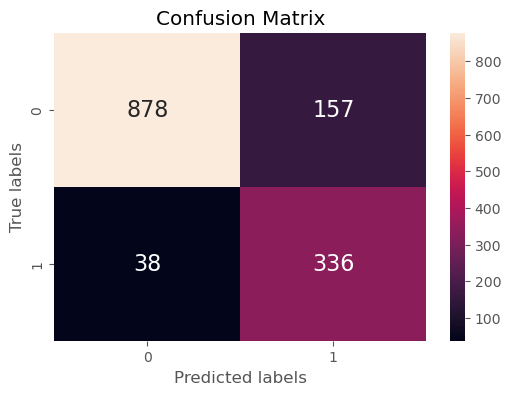

In [11]:
# Running logistic regression model
log_reg_model = modeling(LogisticRegression, 'Logistic Regression', params={'random_state':7})

In [12]:
# Call the cross-validation function
cross_validate_model(log_reg_model, X_train_resampled, y_train_resampled)

Cross-validation scores: [0.91304348 0.89632107 0.85953177 0.88294314 0.86622074 0.87959866
 0.86956522 0.92307692 0.87625418 0.85618729]
Mean CV accuracy: 0.8822742474916387
Standard deviation of CV accuracy: 0.021141780106059015


AUC Score: 0.9409



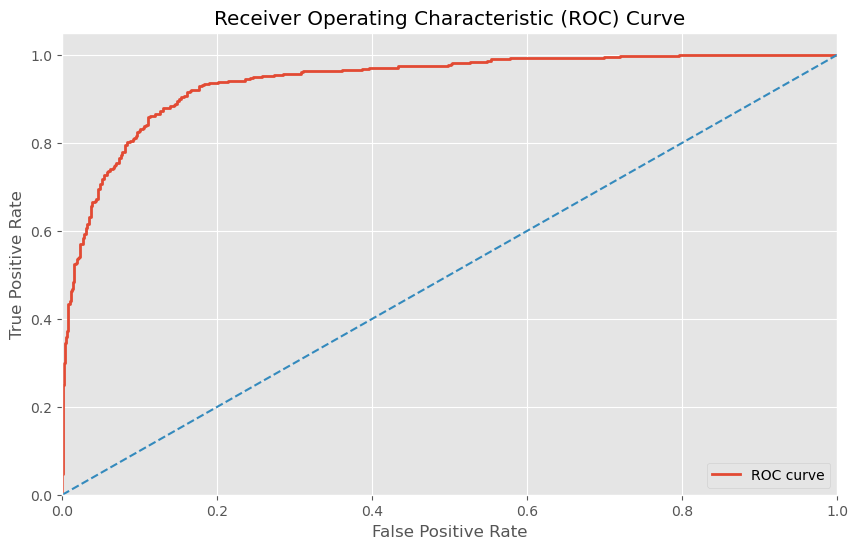

AUC Score: 0.9409


In [13]:
#Call our plot_roc_auc function for the Logistic Regression Model
plot_roc_auc(log_reg_model, y_test);

## The first model we tested and scored was an out of the box logistic regression model and it has done quite well. We could do to increase our precision & f1, but our accuracy & recall are all very high for the first model we've tested. In this use case we want to maximize recall to minimize our false negative rate. 

## Next we will test a Random Forest Model

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1035
           1       0.71      0.84      0.77       374

    accuracy                           0.87      1409
   macro avg       0.82      0.86      0.84      1409
weighted avg       0.88      0.87      0.87      1409

Random Forest Classifier
accuracy:  0.865152590489709
precision:  0.7062780269058296
recall:  0.8422459893048129
f1_score:  0.868643037609092
Matthews correlation coefficient: 0.6794254657851484


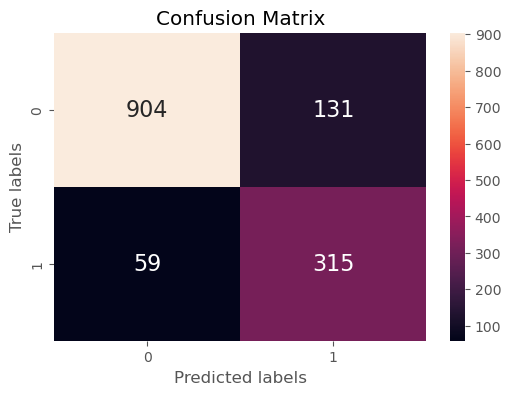

In [14]:
# Random Forest Model

rf_model = modeling(RandomForestClassifier, 'Random Forest Classifier', params={'random_state':7})

In [15]:
# Call the cross-validation function on the Random Forest Model
cross_validate_model(rf_model, X_train_resampled, y_train_resampled)

Cross-validation scores: [0.88628763 0.89966555 0.8361204  0.88628763 0.83946488 0.87959866
 0.86287625 0.90301003 0.85953177 0.85618729]
Mean CV accuracy: 0.8709030100334447
Standard deviation of CV accuracy: 0.022395543869944076


AUC Score: 0.9372



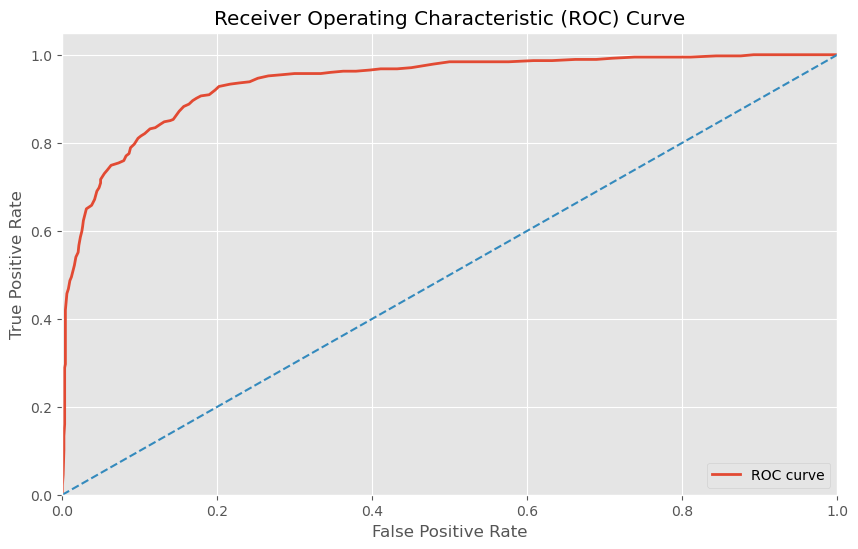

AUC Score: 0.9372


In [16]:
#Call our plot_roc_auc function for the Random Forest Model
plot_roc_auc(rf_model, y_test);

# We could continue in this fashion to test more models, or additionally, we can test as many models as we want and score them all in one block below. We may lose some readability, but we gain much more in efficiency and repeatability. Knowing this, we will continue on by testing all the models and scoring them at once.

Training Logistic Regression
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      1035
           1       0.68      0.90      0.78       374

    accuracy                           0.86      1409
   macro avg       0.82      0.87      0.84      1409
weighted avg       0.88      0.86      0.87      1409

Logistic Regression
accuracy:  0.8616039744499645
precision:  0.6815415821501014
recall:  0.8983957219251337
f1_score:  0.8668810522776931
Matthews correlation coefficient: 0.6913274177578941


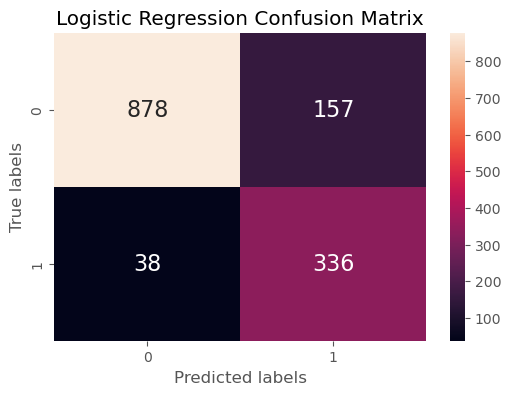

Cross-validation scores: [0.91304348 0.89632107 0.85953177 0.88294314 0.86622074 0.87959866
 0.86956522 0.92307692 0.87625418 0.85618729]
Mean CV accuracy: 0.8822742474916387
Standard deviation of CV accuracy: 0.021141780106059015
AUC Score for Logistic Regression: 0.9409

AUC Score: 0.9409



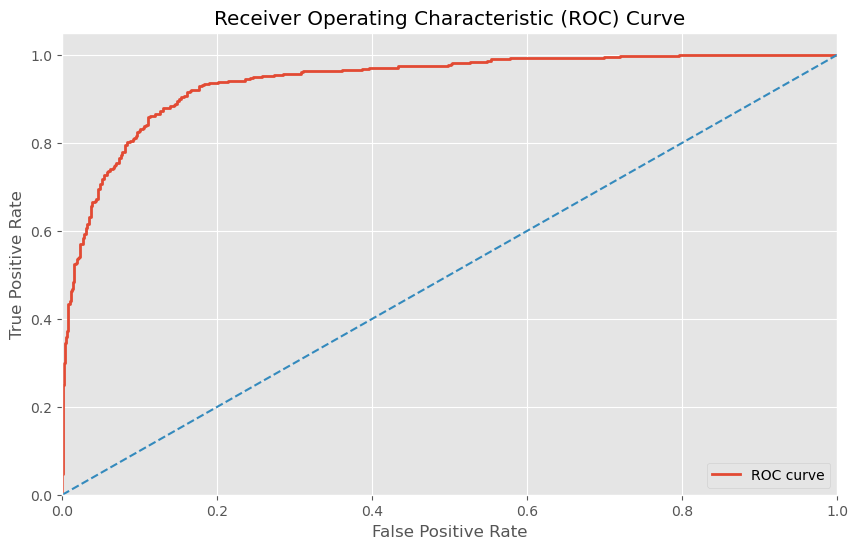

AUC Score: 0.9409
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Decision Tree
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85      1035
           1       0.59      0.79      0.67       374

    accuracy                           0.80      1409
   macro avg       0.75      0.79      0.76      1409
weighted avg       0.83      0.80      0.80      1409

Decision Tree
accuracy:  0.7963094393186657
precision:  0.5861386138613861
recall:  0.7914438502673797
f1_score:  0.8046070181042219
Matthews correlation coefficient: 0.5428356240307588


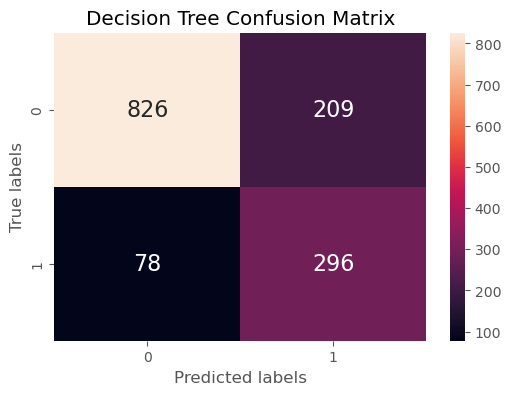

Cross-validation scores: [0.81939799 0.82608696 0.77926421 0.7993311  0.7826087  0.83277592
 0.81270903 0.87959866 0.76588629 0.80936455]
Mean CV accuracy: 0.8107023411371237
Standard deviation of CV accuracy: 0.03076923076923075
AUC Score for Decision Tree: 0.7948

AUC Score: 0.7948



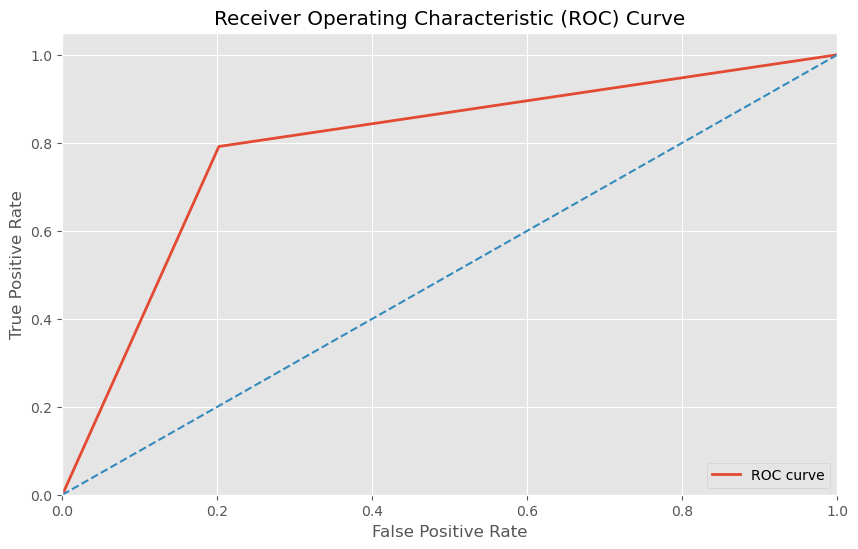

AUC Score: 0.7948
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Random Forest
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      1035
           1       0.71      0.84      0.77       374

    accuracy                           0.87      1409
   macro avg       0.82      0.86      0.84      1409
weighted avg       0.88      0.87      0.87      1409

Random Forest
accuracy:  0.865152590489709
precision:  0.7062780269058296
recall:  0.8422459893048129
f1_score:  0.868643037609092
Matthews correlation coefficient: 0.6794254657851484


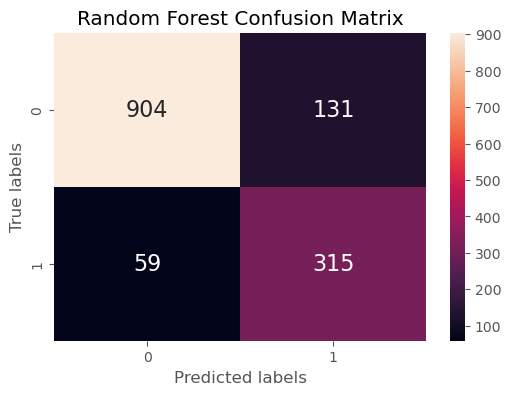

Cross-validation scores: [0.88628763 0.89966555 0.8361204  0.88628763 0.83946488 0.87959866
 0.86287625 0.90301003 0.85953177 0.85618729]
Mean CV accuracy: 0.8709030100334447
Standard deviation of CV accuracy: 0.022395543869944076
AUC Score for Random Forest: 0.9372

AUC Score: 0.9372



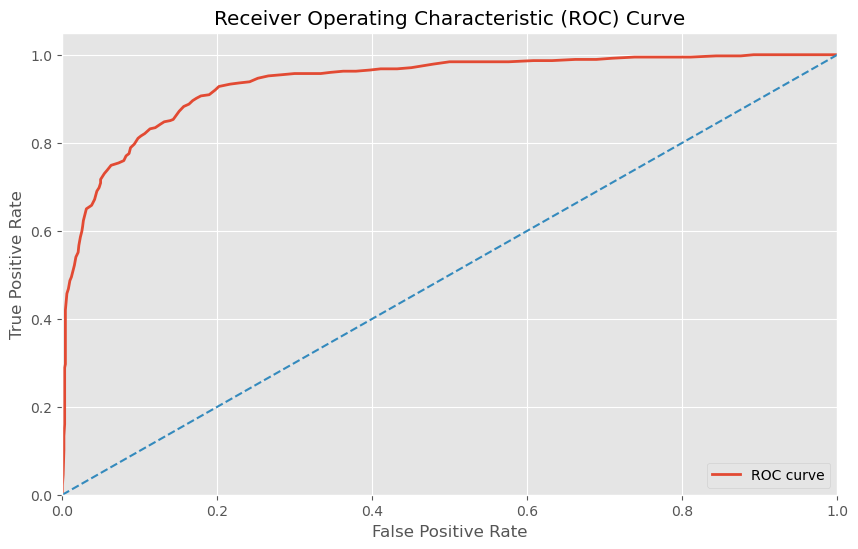

AUC Score: 0.9372
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Gradient Boosting
Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

           0       0.95      0.86      0.91      1035
           1       0.70      0.88      0.78       374

    accuracy                           0.87      1409
   macro avg       0.83      0.87      0.84      1409
weighted avg       0.88      0.87      0.87      1409

Gradient Boosting
accuracy:  0.8672817601135557
precision:  0.6985138004246284
recall:  0.8796791443850267
f1_score:  0.8716368553595588
Matthews correlation coefficient: 0.6949914994912207


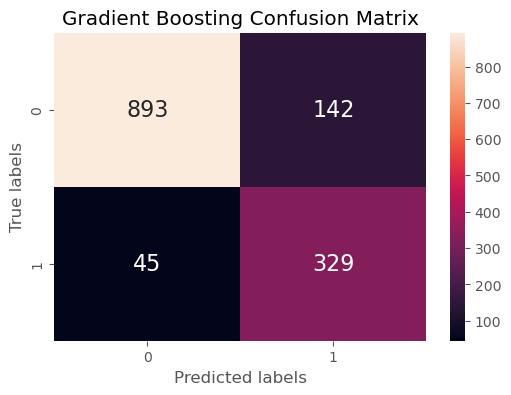

Cross-validation scores: [0.88963211 0.88963211 0.85284281 0.88963211 0.85953177 0.89297659
 0.85284281 0.91973244 0.86956522 0.86287625]
Mean CV accuracy: 0.8779264214046822
Standard deviation of CV accuracy: 0.0206844763826973
AUC Score for Gradient Boosting: 0.9465

AUC Score: 0.9465



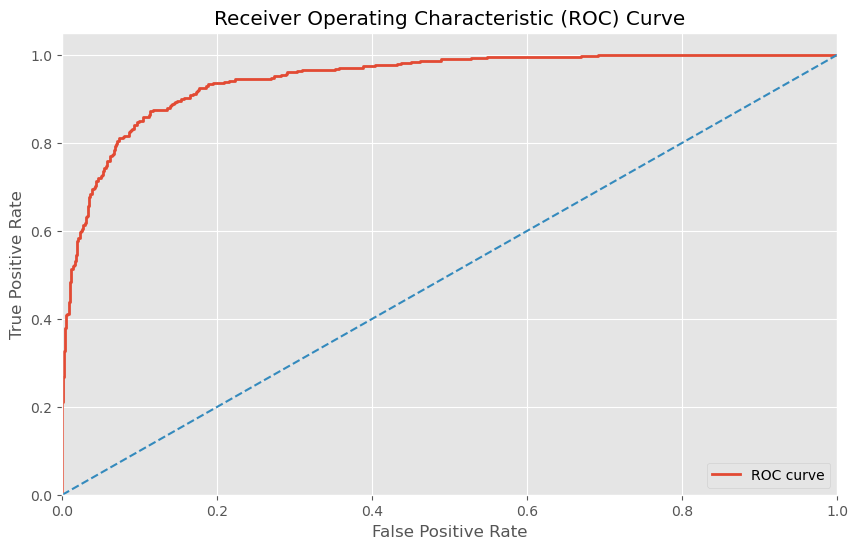

AUC Score: 0.9465
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training XGBoost
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      1035
           1       0.75      0.89      0.81       374

    accuracy                           0.89      1409
   macro avg       0.85      0.89      0.87      1409
weighted avg       0.90      0.89      0.89      1409

XGBoost
accuracy:  0.8907026259758695
precision:  0.748868778280543
recall:  0.8850267379679144
f1_score:  0.893400484067624
Matthews correlation coefficient: 0.7401820984956562


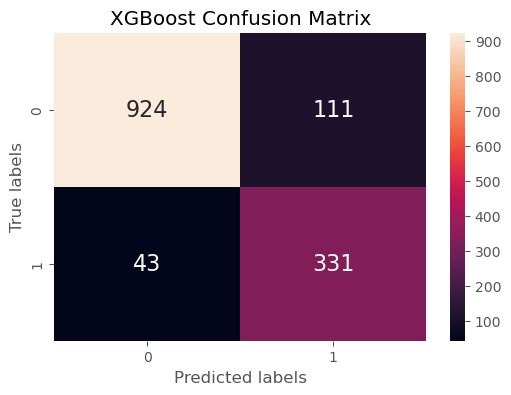

Cross-validation scores: [0.89966555 0.91973244 0.88628763 0.91304348 0.89297659 0.90301003
 0.88963211 0.91304348 0.8729097  0.89297659]
Mean CV accuracy: 0.8983277591973244
Standard deviation of CV accuracy: 0.013560625373052377
AUC Score for XGBoost: 0.9578

AUC Score: 0.9578



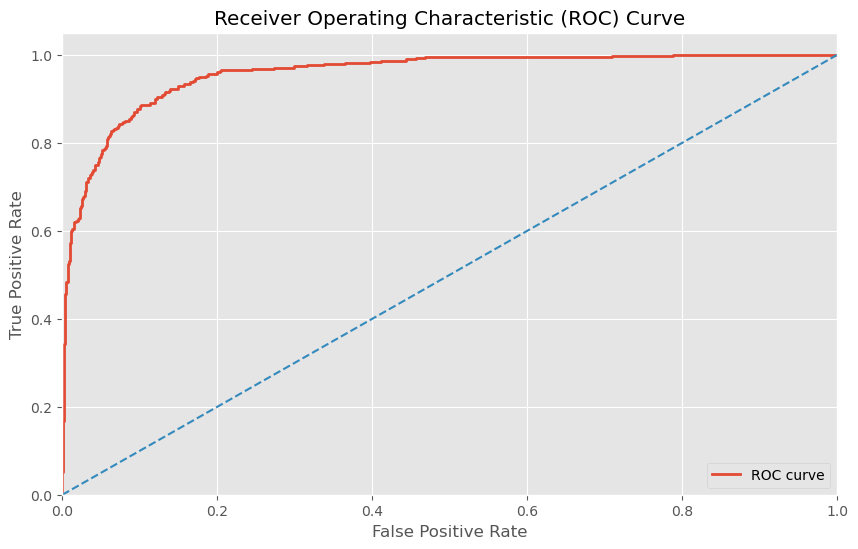

AUC Score: 0.9578
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training CatBoost
Classification Report for CatBoost:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      1035
           1       0.76      0.90      0.83       374

    accuracy                           0.90      1409
   macro avg       0.86      0.90      0.88      1409
weighted avg       0.91      0.90      0.90      1409

CatBoost
accuracy:  0.8992193044712562
precision:  0.7612612612612613
recall:  0.9037433155080213
f1_score:  0.9017677747487772
Matthews correlation coefficient: 0.7616598706596073


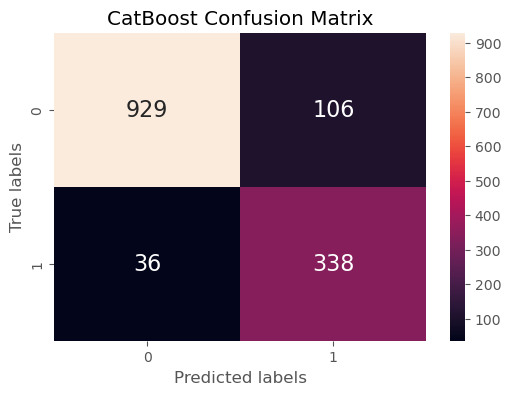

Cross-validation scores: [0.91304348 0.9264214  0.86622074 0.92307692 0.87625418 0.89966555
 0.87959866 0.9264214  0.90635452 0.88963211]
Mean CV accuracy: 0.9006688963210701
Standard deviation of CV accuracy: 0.020888958487795598
AUC Score for CatBoost: 0.9642

AUC Score: 0.9642



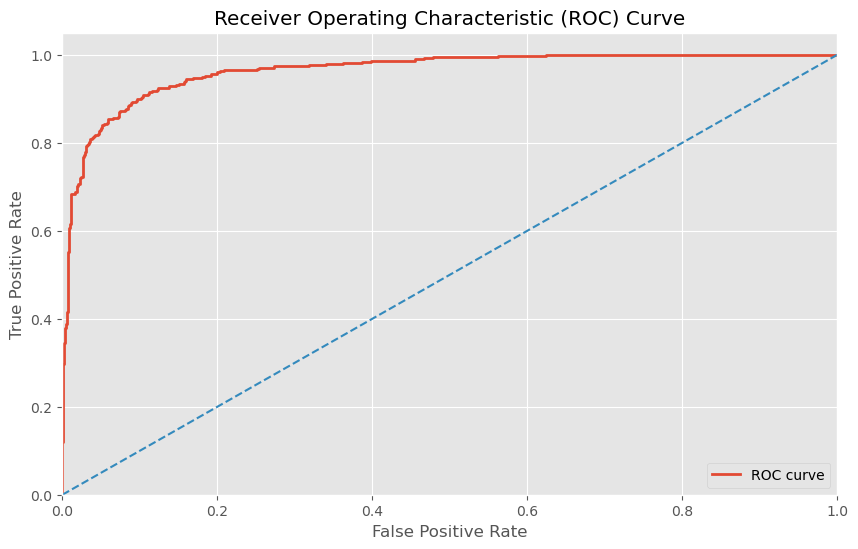

AUC Score: 0.9642
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training SVM
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      1035
           1       0.74      0.92      0.82       374

    accuracy                           0.89      1409
   macro avg       0.85      0.90      0.87      1409
weighted avg       0.91      0.89      0.90      1409

SVM
accuracy:  0.8928317955997161
precision:  0.7408207343412527
recall:  0.9171122994652406
f1_score:  0.8961221452895168
Matthews correlation coefficient: 0.7531729907828809


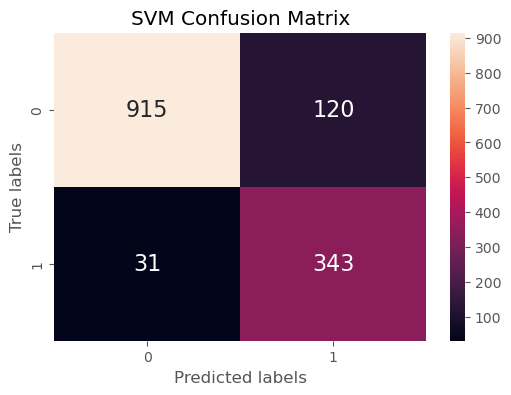

Cross-validation scores: [0.92307692 0.92976589 0.87625418 0.91304348 0.87625418 0.89966555
 0.88294314 0.91638796 0.89632107 0.89632107]
Mean CV accuracy: 0.9010033444816055
Standard deviation of CV accuracy: 0.018146702295987357
AUC Score for SVM: 0.9589

AUC Score: 0.9589



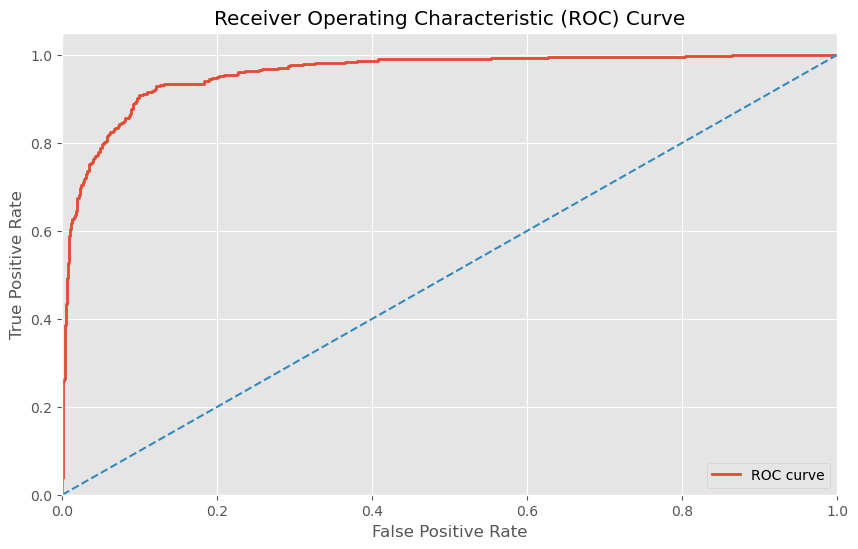

AUC Score: 0.9589
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training KNN
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.93      0.73      0.82      1035
           1       0.53      0.84      0.65       374

    accuracy                           0.76      1409
   macro avg       0.73      0.79      0.73      1409
weighted avg       0.82      0.76      0.77      1409

KNN
accuracy:  0.7608232789212207
precision:  0.5310924369747899
recall:  0.8449197860962567
f1_score:  0.773804130064756
Matthews correlation coefficient: 0.5143643455162675


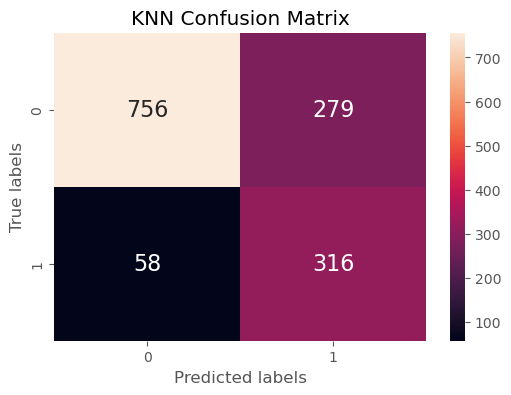

Cross-validation scores: [0.78595318 0.7826087  0.79598662 0.82608696 0.78929766 0.82274247
 0.76923077 0.86287625 0.79598662 0.80602007]
Mean CV accuracy: 0.8036789297658864
Standard deviation of CV accuracy: 0.02577855608366973
AUC Score for KNN: 0.8639

AUC Score: 0.8639



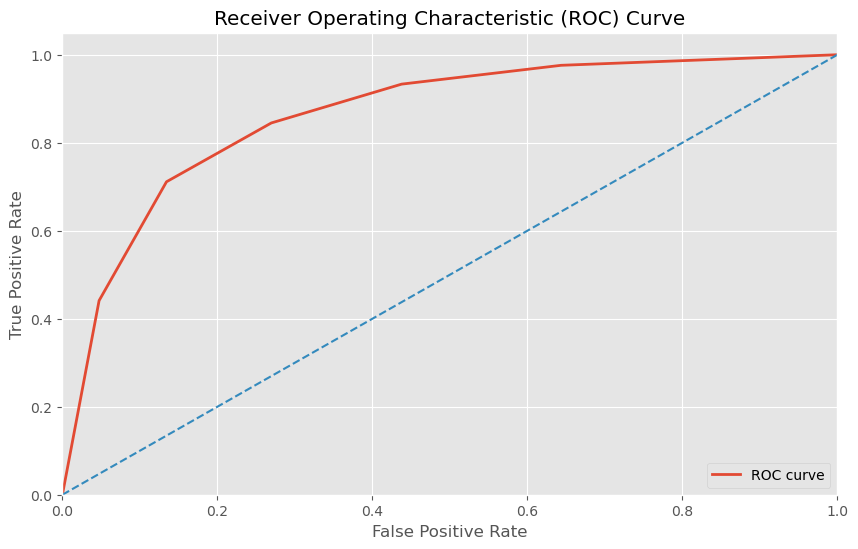

AUC Score: 0.8639
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Naive Bayes
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87      1035
           1       0.62      0.83      0.71       374

    accuracy                           0.82      1409
   macro avg       0.77      0.82      0.79      1409
weighted avg       0.85      0.82      0.83      1409

Naive Bayes
accuracy:  0.8197303051809794
precision:  0.62
recall:  0.8288770053475936
f1_score:  0.8268825003574481
Matthews correlation coefficient: 0.5955279213727456


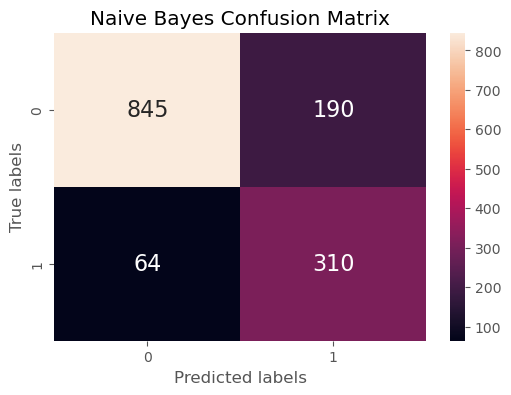

Cross-validation scores: [0.84615385 0.84280936 0.80936455 0.84615385 0.83277592 0.84949833
 0.7993311  0.86956522 0.83277592 0.81605351]
Mean CV accuracy: 0.8344481605351171
Standard deviation of CV accuracy: 0.020025039973140726
AUC Score for Naive Bayes: 0.9097

AUC Score: 0.9097



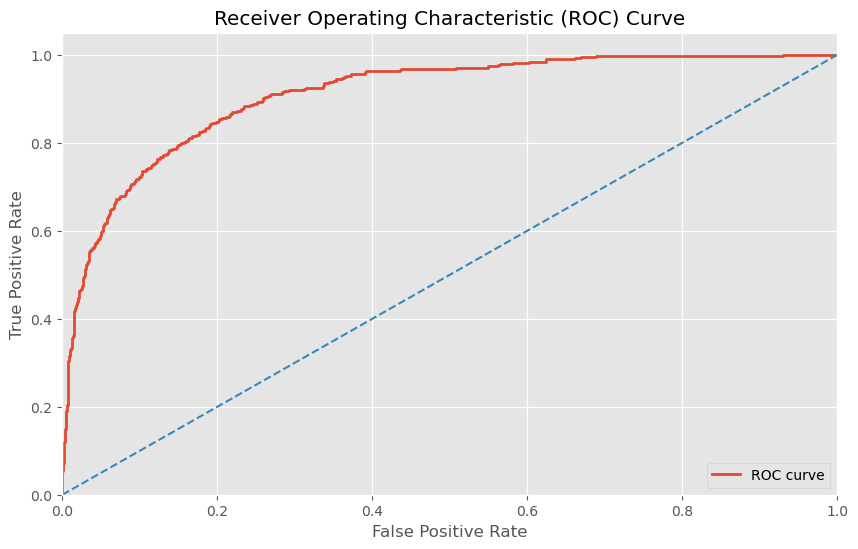

AUC Score: 0.9097
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Neural Network
Classification Report for Neural Network:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      1035
           1       0.86      0.95      0.90       374

    accuracy                           0.95      1409
   macro avg       0.92      0.95      0.93      1409
weighted avg       0.95      0.95      0.95      1409

Neural Network
accuracy:  0.9453513129879347
precision:  0.8613138686131386
recall:  0.946524064171123
f1_score:  0.9461419169936459
Matthews correlation coefficient: 0.86599934474188


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


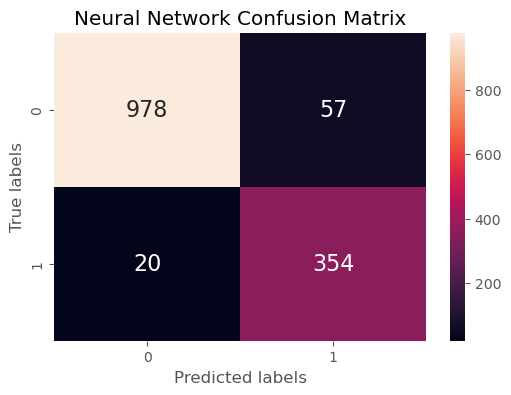

Cross-validation scores: [0.95317726 0.94314381 0.9264214  0.93645485 0.91638796 0.94648829
 0.9264214  0.94983278 0.91973244 0.89966555]
Mean CV accuracy: 0.9317725752508362
Standard deviation of CV accuracy: 0.016192265467438422
AUC Score for Neural Network: 0.9872

AUC Score: 0.9872



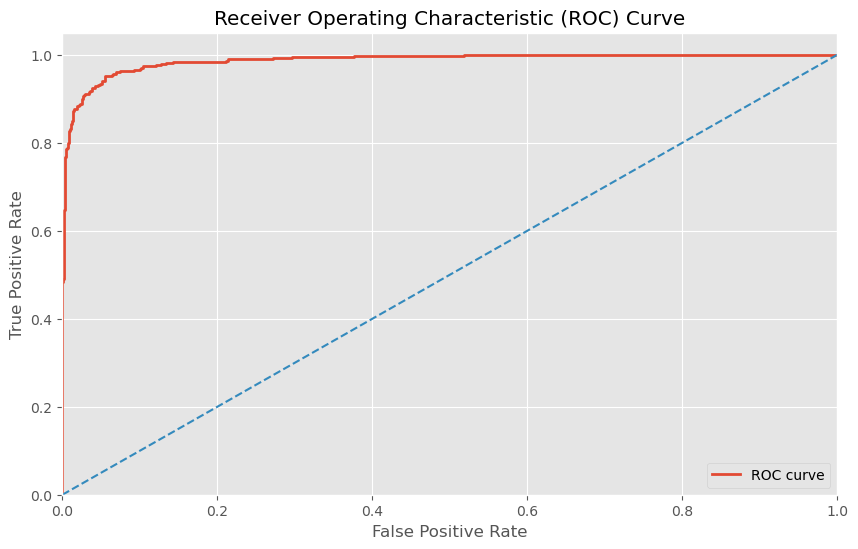

AUC Score: 0.9872
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


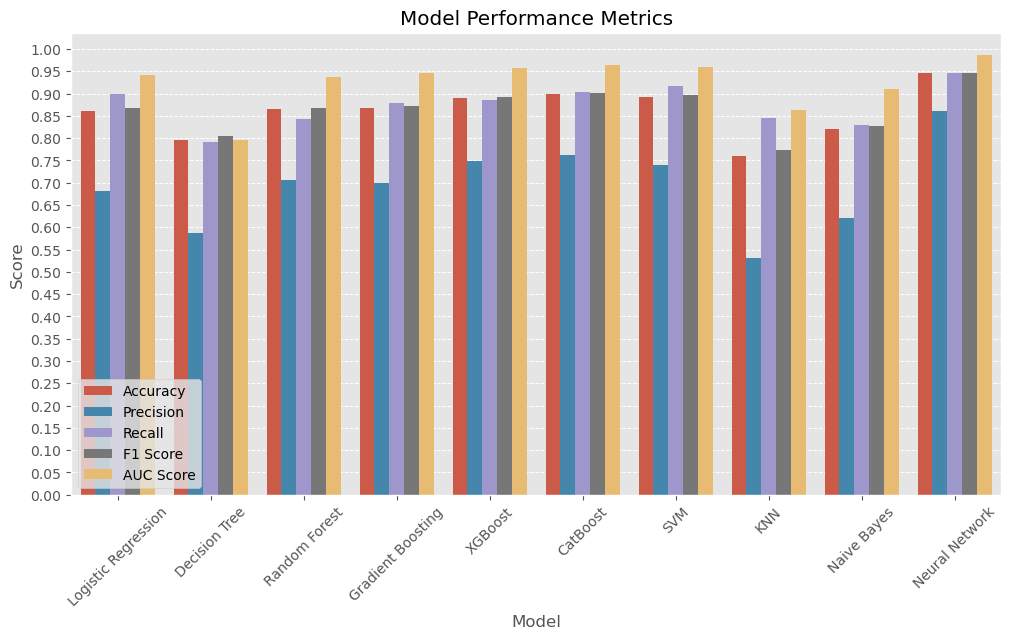

In [17]:
#Import Packages specific to this block (whole black can be taken and re-used for other modeling tasks)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score


# List of 10 models to test
models = [
    ('Logistic Regression', LogisticRegression(random_state=7)),
    ('Decision Tree', DecisionTreeClassifier(random_state=7)),
    ('Random Forest', RandomForestClassifier(random_state=7)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=7)),
    ('XGBoost', XGBClassifier(random_state=7)),
    ('CatBoost', CatBoostClassifier(random_state=7, verbose=0)),
    ('SVM', SVC(probability=True, random_state=7)),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(random_state=7, max_iter=500))
]


# DataFrame to store scores for use in our plot of all scoring metrics of all models at the end
scores_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score'])


# Loop through models
for name, model in models:
    print(f"Training {name}")
    global y_pred
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_pipe)

    #Performance evaluation
    def print_scores(model, y_test, y_pred):
        print(name)
        acc_score = accuracy_score(y_test, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_test, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_test, y_pred)
        print("recall: ",rec_score)
        f_score = f1_score(y_test, y_pred, average='weighted')
        print("f1_score: ",f_score)


    
    # Print the classificaiton report for the model
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    print_scores(model, y_test, y_pred)

    
    # Assuming y_test and y_pred are your true labels and predicted labels respectively
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews correlation coefficient:", mcc)

    
    # Calculate & plot the confusion matrix as a heatmap
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    
    # Call the cross-validation function on the models
    cross_validate_model(model, X_train_resampled, y_train_resampled)

    # Calculate y probabilities to plot ROC & AUC
    y_proba = model.predict_proba(X_test_pipe)[:, 1] if hasattr(model, "predict_proba") else None
    if y_proba is not None:
        auc_score = roc_auc_score(y_test, y_proba)
        print(f"AUC Score for {name}: {auc_score:.4f}\n")
    else:
        print("\n")

    #Call our plot_roc_auc function for the Model
    plot_roc_auc(model, y_test)
        


     # Calculate scores for scoring plot at the end to review
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # Append scores to DataFrame
    scores_df = pd.concat([scores_df, pd.DataFrame([{
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }])], ignore_index=True)


    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")



# Melt the DataFrame we created of all the scores for all models for easier plotting with seaborn
scores_melted = scores_df.melt(id_vars='Model', var_name='Metric', value_name='Score')


# Plot the bar plot of scoring metrics for all models
plt.figure(figsize=(12, 6))
sns.barplot(data=scores_melted, x='Model', y='Score', hue='Metric')
plt.xticks(rotation=45)
plt.title('Model Performance Metrics')
plt.legend(loc="lower left")
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.7) # Add gridlines every 0.05 units on the y-axis
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.05))
plt.show()

## We've done quite a bit with this block. We've trained and scored 10 models then compared their scoring metrics all at once. Our final plot brings it all together. As I stated earlier, in this use-case, we want to maximize for recall. We can do with misclassifying a customer who will not churn as one who will, but we can't do anything to try to stop a customer from churning if we can't identify them in the first place by misclassifying them as not churning.
## Now we'll choose 3 models to tune. I always like to include a simple model to give us an option for low computational cost. Our logistic regression model has a high recall and good overall accuray as well. The two models with the highest recall are our SVM and Neural Network so we will tune these as well.

## We'll begin by tuning our logistic regression model first.

Time taken for GridSearchCV: 2.41 seconds
Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}
Best Cross-Validation Score: 0.8846
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1035
           1       0.68      0.90      0.78       374

    accuracy                           0.86      1409
   macro avg       0.82      0.87      0.84      1409
weighted avg       0.89      0.86      0.87      1409



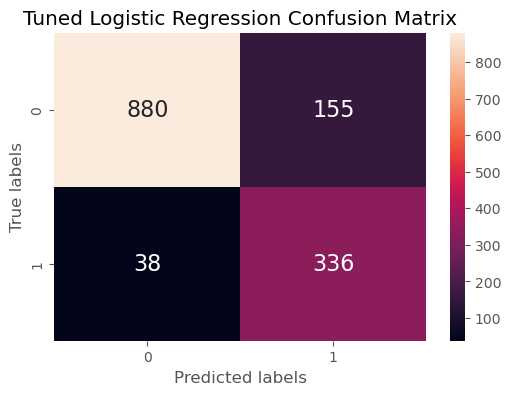

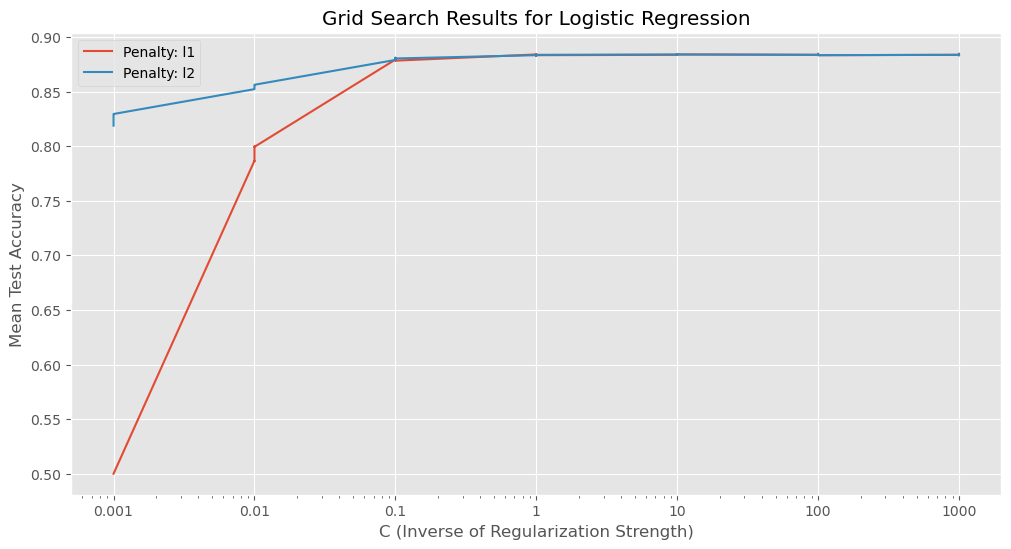

In [18]:
# Logistic Regression Hyperparameter tuning

# Define the model
log_reg = LogisticRegression(multi_class='auto', random_state=7)

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'tol': [1e-4, 1e-3, 1e-2],
    'solver': ['liblinear', 'saga'],
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

# Measure the time taken to run GridSearchCV
start_time = time.time()

# Run GridSearchCV on the training data
grid_search.fit(X_train_resampled, y_train_resampled)

end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f'Time taken for GridSearchCV: {elapsed_time:.2f} seconds')

# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {grid_search.best_score_:.4f}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pipe)
print(classification_report(y_test, y_pred))

# Calculate & plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned Logistic Regression Confusion Matrix')
plt.show()

# Extracting results from GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

# Plotting
plt.figure(figsize=(12, 6))

# Plot mean test scores for each parameter combination
for penalty in param_grid['penalty']:
    subset = results[results['param_penalty'] == penalty]
    plt.plot(subset['param_C'], subset['mean_test_score'], label=f'Penalty: {penalty}')

plt.xscale('log')
plt.xticks(param_grid['C'], labels=[str(x) for x in param_grid['C']])
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Mean Test Accuracy')
plt.title('Grid Search Results for Logistic Regression')
plt.legend()
plt.show()

Time taken for GridSearchCV: 345.55 seconds
Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.9237
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1035
           1       0.81      0.93      0.87       374

    accuracy                           0.92      1409
   macro avg       0.89      0.93      0.91      1409
weighted avg       0.93      0.92      0.93      1409



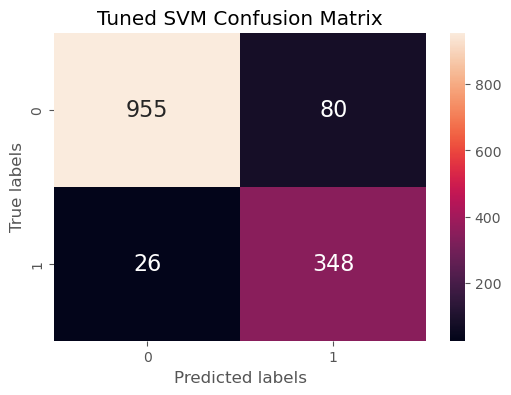

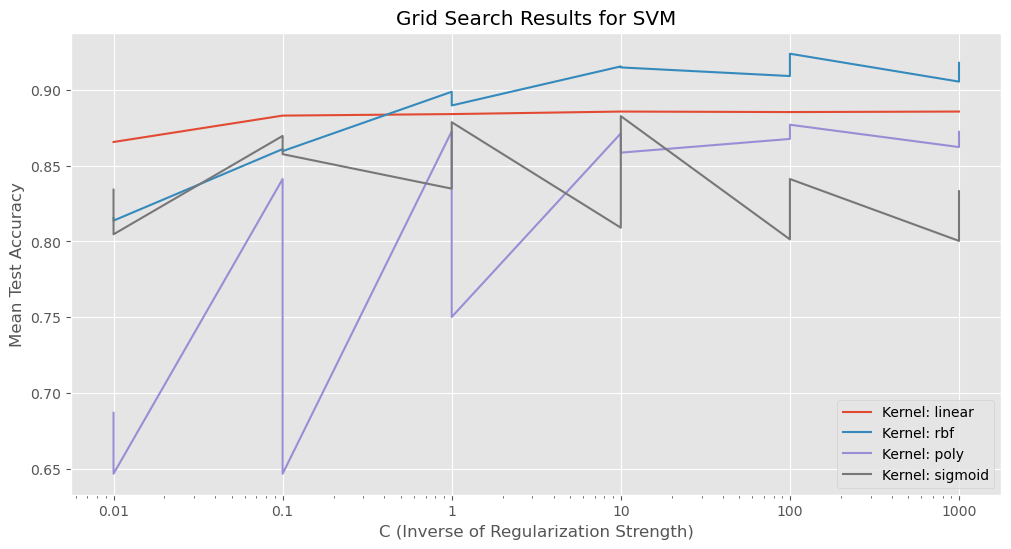

In [19]:
# SVM Hyperparameter tuning

# Define the model
svm = SVC(probability=True, random_state=7)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Measure the time taken to run GridSearchCV
start_time = time.time()

# Run GridSearchCV on the training data
grid_search.fit(X_train_resampled, y_train_resampled)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f'Time taken for GridSearchCV: {elapsed_time:.2f} seconds')


# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {grid_search.best_score_:.4f}')


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pipe)
print(classification_report(y_test, y_pred))


# Calculate & plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned SVM Confusion Matrix')
plt.show()

# Extracting results from GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

# Plotting
plt.figure(figsize=(12, 6))

# Plot mean test scores for each parameter combination
for kernel in param_grid['kernel']:
    subset = results[results['param_kernel'] == kernel]
    plt.plot(subset['param_C'], subset['mean_test_score'], label=f'Kernel: {kernel}')

plt.xscale('log')
plt.xticks(param_grid['C'], labels=[str(x) for x in param_grid['C']])
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Mean Test Accuracy')
plt.title('Grid Search Results for SVM')
plt.legend()
plt.show()

Time taken for RandomizedSearchCV: 284.98 seconds
Best Parameters: {'activation': 'relu', 'alpha': 0.41611594308786626, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.03766815128463097, 'solver': 'sgd'}
Best Cross-Validation Score: 0.9328
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1035
           1       0.82      0.95      0.88       374

    accuracy                           0.93      1409
   macro avg       0.90      0.94      0.92      1409
weighted avg       0.94      0.93      0.94      1409



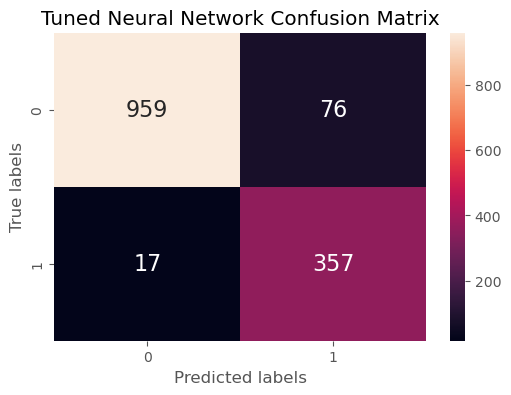

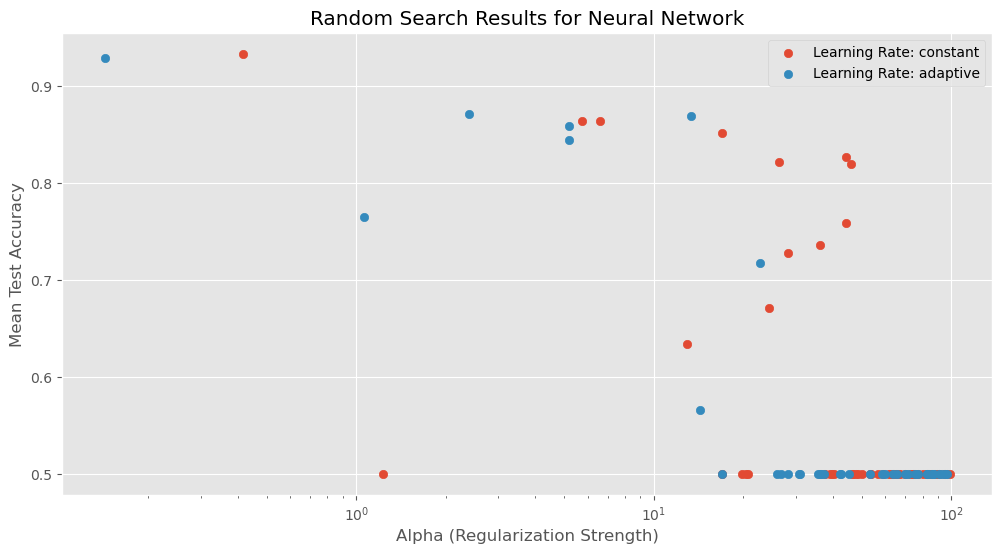

In [20]:
# Neural Network Hyperparameter tuning


# Define the model
nn = MLPClassifier(random_state=7, max_iter=2000)

# Define the parameter distributions
param_distributions = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': uniform(0.0001, 100),  # Uniform distribution between 0.0001 and 10
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': uniform(0.001, 1.0)  # Uniform distribution between 0.001 and 0.1
}

# Initialize RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(nn, param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=7)

# Measure the time taken to run RandomizedSearchCV
start_time = time.time()

# Run RandomizedSearchCV on the training data
random_search.fit(X_train_resampled, y_train_resampled)

end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f'Time taken for RandomizedSearchCV: {elapsed_time:.2f} seconds')

# Print the best parameters and the best score
print(f'Best Parameters: {random_search.best_params_}')
print(f'Best Cross-Validation Score: {random_search.best_score_:.4f}')

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_pipe)
print(classification_report(y_test, y_pred))

# Calculate & plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned Neural Network Confusion Matrix')
plt.show()

# Extracting results from RandomizedSearchCV
results = pd.DataFrame(random_search.cv_results_)

# Plotting
plt.figure(figsize=(12, 6))

# Plot mean test scores for each value of alpha, grouped by learning_rate
for learning_rate in param_distributions['learning_rate']:
    subset = results[results['param_learning_rate'] == learning_rate]
    plt.scatter(subset['param_alpha'], subset['mean_test_score'], label=f'Learning Rate: {learning_rate}')

plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Test Accuracy')
plt.title('Random Search Results for Neural Network')
plt.legend()
plt.show()

# Conclusion

### After hyperparameter tuning our top three models, the Neural Network is the clear choice for this dataset with an accuracy of 93% and recall of 95%.

### The SVM, although it did well with an accuracy of 92% and recall of 93%, the Neural Network bests the SVM in both scoring metrics.

### The logistic regression model, although much simpler, was far less accurate at 86% and had a lower recall at 90%.

Cross-validation scores: [0.95317726 0.94314381 0.92976589 0.93979933 0.91973244 0.93645485
 0.93311037 0.94314381 0.90301003 0.93311037]
Mean CV accuracy: 0.9334448160535118
Standard deviation of CV accuracy: 0.013247693859758117
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1035
           1       0.82      0.95      0.88       374

    accuracy                           0.93      1409
   macro avg       0.90      0.94      0.92      1409
weighted avg       0.94      0.93      0.94      1409



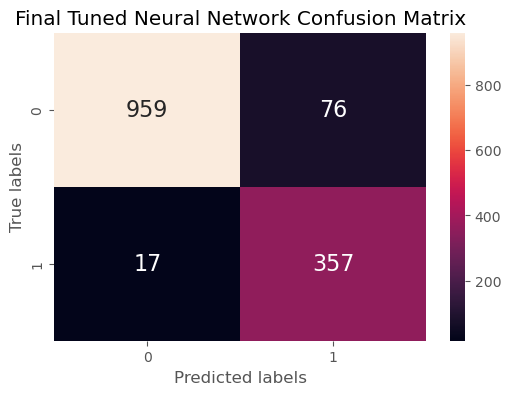

In [21]:
#Instantiate & fit our final model
nn_final = MLPClassifier(activation='relu',
                         alpha=0.41611594308786626,
                         hidden_layer_sizes= (50, 50, 50),
                         learning_rate='constant',
                         learning_rate_init=0.03766815128463097,
                         solver='sgd',
                         random_state=7,
                         max_iter=2000)
nn_final.fit(X_train_resampled, y_train_resampled)

#Predict & Cross Validate
y_pred = nn_final.predict(X_test_pipe)
cross_validate_model(nn_final, X_train_resampled, y_train_resampled)
print("-----------------------------------------------------")

#Print Final Classification Report
print(classification_report(y_test, y_pred))

# Calculate & plot final confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Final Tuned Neural Network Confusion Matrix')
plt.show()

## With our final model complete, we will now export the model to predict on future data.

In [22]:
#Exporting the model

# Define the file path
folder_path = '../models'
joblib_file = os.path.join(folder_path, "nn_final_model.joblib")

# Export the model
joblib.dump(nn_final, joblib_file)

# To load the model later
# loaded_model = joblib.load(joblib_file)
# y_pred_loaded = loaded_model.predict(X_test_pipe)

['../models/nn_final_model.joblib']

# Lastly we will make good on our goal of determining which features contribute most to a customer staying with the company or churning.

In [23]:
# Calculate permutation feature importance
result = permutation_importance(nn_final, X_test_pipe, y_test, n_repeats=10, random_state=7, n_jobs=-1)

# Get the importance
feature_importance = result.importances_mean

# Get the PCA components
pca_components = pca.components_

# Map feature importance from PCA components to original features
original_feature_importance = np.dot(feature_importance, pca_components)

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': original_feature_importance})
feature_importance_df['Absolute Importance'] = feature_importance_df['Importance'].apply(abs)
feature_importance_df.sort_values(by='Absolute Importance', ascending=False, inplace=True)

print(feature_importance_df)

                              Feature  Importance  Absolute Importance
46                     Dependents_Yes    0.157288             0.157288
0                  Satisfaction Score    0.113037             0.113037
21                      Offer_Offer E   -0.112718             0.112718
38                  Contract_Two Year    0.095748             0.095748
4                    Tenure in Months    0.094930             0.094930
20                      Offer_Offer D    0.084382             0.084382
45                        Married_Yes    0.083249             0.083249
17              Referred a Friend_Yes    0.078505             0.078505
22                 Offer_Unknown/None   -0.074026             0.074026
32           Premium Tech Support_Yes    0.072538             0.072538
1                         Churn Score   -0.071103             0.071103
3                 Number of Referrals    0.054613             0.054613
11        Total Long Distance Charges    0.051540             0.051540
27    

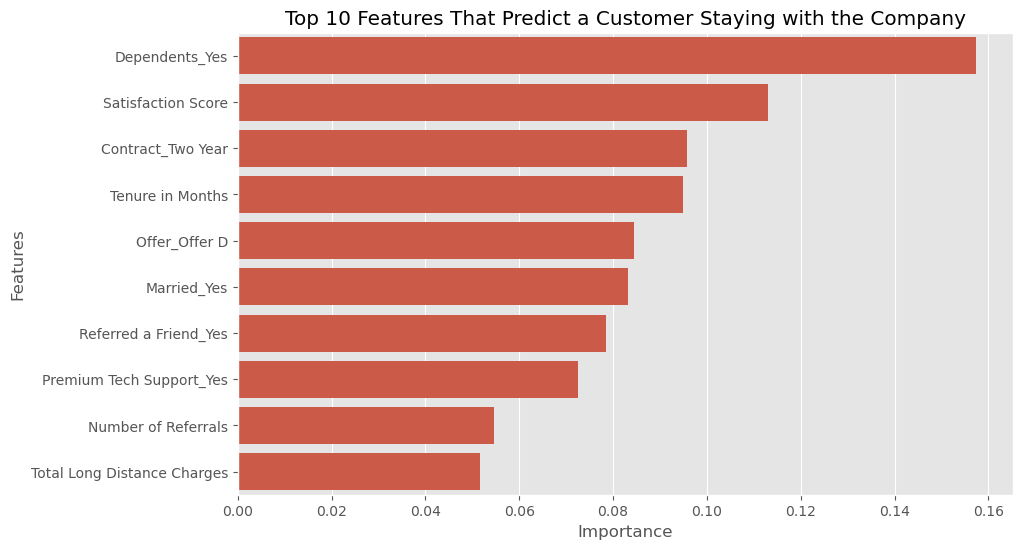

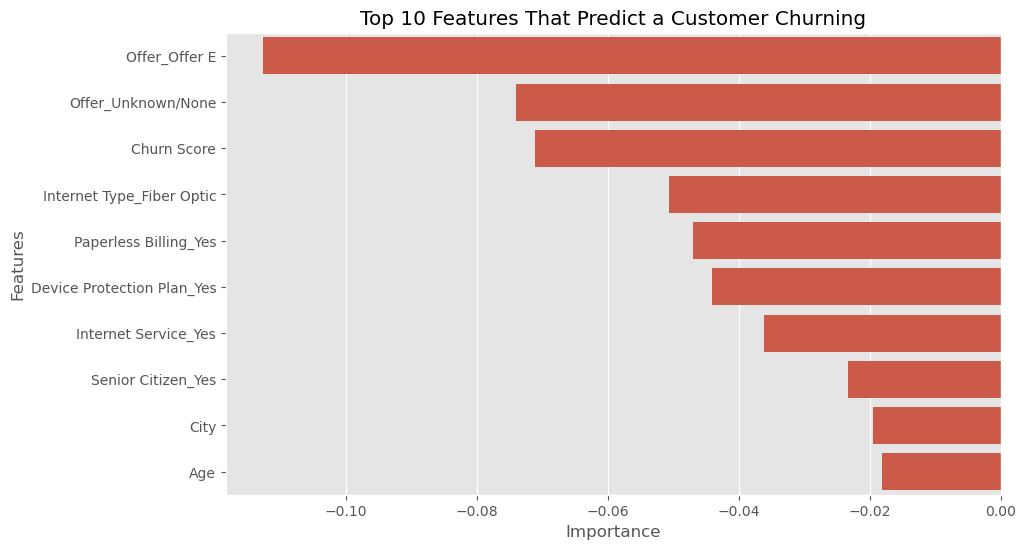

In [24]:
# Filter positive and negative importance
top_positive_features = feature_importance_df[feature_importance_df['Importance'] > 0].head(10)
top_negative_features = feature_importance_df[feature_importance_df['Importance'] < 0].head(10)

# Plot for top 10 positive importance features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_positive_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Features That Predict a Customer Staying with the Company')
plt.show()

# Plot for top 10 negative importance features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_negative_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Features That Predict a Customer Churning')
plt.show()